In [2]:
from network_evaluation_tools import gene_conversion_tools as gct
from network_evaluation_tools import data_import_tools as dit
import pandas as pd
import itertools
import time
import matplotlib.pyplot as plt

In [3]:
wd = '/cellar/users/snwright/Data/Network_Analysis/'

# Version 2.0
## Load Reactome-Functional Interactions Raw Data
#### Source: https://reactome.org/download/tools/ReatomeFIs/FIsInGene_122220_with_annotations.txt
Downloaded: Nov 16, 2021  
Last Updated: Dec 22, 2020    

**Notes 2021:** 
* Gene naming appears to have improved. 
* Again ~85% of all interactions have the maximum score of 1.0 
* From Reactome: "The number of predicted FIs has dropped about 50% from Version 2019 to Version 2020 most likely because we excluded BioGrid protein-protein interactions collected in iRefIndex. We found an abnormal high odds ratio for mapped worm protein-protein interaction feature from BioGrid, which was much higher than human PPIs (120 vs. 80) and other no-human PPI features."


In [37]:
Reactome_FIs_Raw_v2 = pd.read_csv(wd+'Network_Data_Raw/Reactome/FIsInGene_122220_with_annotations.txt',sep='\t')
print('Raw edges in ReactomeFI:', Reactome_FIs_Raw_v2.shape[0])

Raw edges in ReactomeFI: 259151


In [38]:
Reactome_FIs_Raw_v2.head()

,Gene1,Gene2,Annotation,Direction,Score
0,16-5-5,CDC42,predicted,-,0.98
1,16-5-5,PARD3,predicted,-,1.00
2,16-5-5,PARD3B,predicted,-,1.00
3,A1CF,APOBEC1,catalyzed by; complex; input,<-,1.00
4,A1CF,EP300,expression regulated by,<-,1.00


In [41]:
Reactome_FIs_Raw_v2.Annotation.value_counts()

complex; input                                                                                                  64423
predicted                                                                                                       41182
complex                                                                                                         16502
catalyzed by                                                                                                    11337
catalyze                                                                                                        10691
                                                                                                                ...  
PPrel: activated by; complex; input; predicted; reaction                                                            1
PPrel: activated by; PPrel: activation; activate; activated by; complex; inhibited by; input; reaction              1
activated by; complex; inhibited by; input; reaction    

In [39]:
# Extract gene list
Reactome_FIs_Raw_Genes_v2 = list(set(Reactome_FIs_Raw_v2['Gene1']).union(set(Reactome_FIs_Raw_v2['Gene2'])))

In [40]:
# Find "invalid genes" by text format
query_string_v2, valid_genes_v2, invalid_genes_v2 = gct.query_constructor(Reactome_FIs_Raw_Genes_v2, exclude_prefixes=['CHEBI'], print_invalid_genes=True)

13971 Valid Query Genes
35 Invalid Query Genes:
['NUP98/HOXC13', 'KIF5B-RET(NM_020630)_K23', 'WUGSC:H_GS165O14.2', 'OLFR 17-210', 'IKBKAP VARIANT PROTEIN', 'APC VARIANT PROTEIN', 'EPHB2 VARIANT PROTEIN', 'STAG1 VARIANT PROTEIN', 'MIR CL-10', 'PLK-1 DELTA', 'KIF5B-RET(NM_020975)_K15', 'PIK3C2B VARIANT PROTEIN', 'ITGA7 VARIANT PROTEIN', 'SYMPK VARIANT PROTEIN', 'PIK3CA VARIANT PROTEIN', 'KIF5B-RET(NM_020630)_K16', 'KIF5B-RET(NM_020630)_K24', 'YWHAE/FAM22B FUSION', 'TSC1-PDGFRB FUSION', 'KIF5B-RET(NM_020975)_K23', 'KIF5B-RET(NM_020975)_K16', 'OK/SW-CL.65', 'TNC VARIANT PROTEIN', 'PDHA1/LOC79064', 'KIF5B-RET(NM_020630)_K22', 'YWHAE/FAM22A FUSION', 'KIF5B-RET(NM_020975)_K22', 'BCR/ABL FUSION', 'PKB-LIKE 1', 'CD40 LIGAND', 'MYO1F VARIANT PROTEIN', 'KIF5B-RET(NM_020630)_K15', 'PLCG1 VARIANT PROTEIN', 'NUMA1 VARIANT PROTEIN', 'PIK4CA VARIANT PROTEIN']


In [46]:
# Get Edgelist of network
query_edgelist_v2 = Reactome_FIs_Raw_v2[['Gene1','Gene2', 'Score']].values.tolist()

In [47]:
# Filter query edges
query_edgelist_filt_v2 = gct.filter_query_edgelist(query_edgelist_v2,invalid_genes_v2)
query_edgelist_filt_df_v2 = pd.DataFrame(query_edgelist_filt_v2, columns=["symbol_n1", "symbol_n2", "weight"])

743 / 259151 edges with invalid nodes removed


In [48]:
# Filter edge list
ReactomeFI_edgelist_filt_v2 = gct.filter_converted_edgelist(query_edgelist_filt_df_v2, weighted=True)

258408 input edges
0 self-edges removed
0 edges with un-mapped genes removed
0 duplicate edges removed
Edge list filtered: 0.1 seconds
258408 Edges remaining


In [51]:
# Save filtered, converted edge list to file
gct.write_edgelist(ReactomeFI_edgelist_filt_v2, wd+'Processed_Data/Network_SIFs_Symbol/ReactomeFI_Symbol_2020.sif', binary=False)

Edge list saved: 0.32 seconds


In [60]:
# Assess the fraction of edges with the maximum score
q_score = ReactomeFI_edgelist_filt_v2['weight'].quantile(0.9)
print(q_score)
ReactomeFI_edgelist_filt2_v2 = ReactomeFI_edgelist_filt_v2[ReactomeFI_edgelist_filt_v2['weight']>=q_score]
print(ReactomeFI_edgelist_filt2_v2.shape[0], '/', ReactomeFI_edgelist_filt_v2.shape[0], 'edges kept, ', float(ReactomeFI_edgelist_filt2_v2.shape[0])/ReactomeFI_edgelist_filt_v2.shape[0])

1.0
219779 / 258408 edges kept,  0.8505115940682951


# Version 1.0 (original)
## Load Reactome-Functional Interactions Raw Data
#### Source: http://reactomews.oicr.on.ca:8080/caBigR3WebApp2016/FIsInGene_022717_with_annotations.txt.zip
Downloaded: June 15, 2017  
Last Updated: February 27, 2017  
Note about processing: It looks like most of the edges are given as gene symbols but many of them seem to be invalid names, so we will use some of the gene conversion tools to filter these results as best we can.

In [4]:
Reactome_FIs_Raw = pd.read_csv(wd+'Network_Data_Raw/Reactome/FIsInGene_022717_with_annotations.txt',sep='\t')
print('Raw edges in ReactomeFI:', Reactome_FIs_Raw.shape[0])

Raw edges in ReactomeFI: 230243


In [44]:
Reactome_FIs_Raw.Annotation.value_counts()

complex; input                                                                                                  58769
predicted                                                                                                       31807
complex                                                                                                         17348
catalyzed by                                                                                                    12665
catalyze                                                                                                        12638
                                                                                                                ...  
PPrel: activated by; PPrel: activated, indirect effect; activated by; complex; inhibited by; input; reaction        1
PPrel: activated by; PPrel: binding/association; activated by; complex; inhibited by; input; reaction               1
PPrel: activated by, phosphorylation; activated by; comp

In [5]:
# Extract gene list
Reactome_FIs_Raw_Genes = list(set(Reactome_FIs_Raw['Gene1']).union(set(Reactome_FIs_Raw['Gene2'])))

In [6]:
# Find "invalid genes" by text format
query_string, valid_genes, invalid_genes = gct.query_constructor(Reactome_FIs_Raw_Genes, exclude_prefixes=['CHEBI'], print_invalid_genes=True)

12254 Valid Query Genes
23 Invalid Query Genes:
['WUGSC:H_GS165O14.2', 'APC VARIANT PROTEIN', 'EPHB2 VARIANT PROTEIN', 'STAG1 VARIANT PROTEIN', 'MIR CL-10', 'PIK3C2B VARIANT PROTEIN', 'ITGA7 VARIANT PROTEIN', 'PIK3CA VARIANT PROTEIN', 'RUNX1/CBFA2T2 FUSION', 'YWHAE/FAM22B FUSION', 'RUNX1/C20ORF112 FUSION', 'ATP2B2 VARIANT PROTEIN', 'TNC VARIANT PROTEIN', 'PDHA1/LOC79064', 'IGKV A18', 'YWHAE/FAM22A FUSION', 'BCR/ABL FUSION', 'BETA 2-MICROGLOBULIN', '<ALPHA><BETA>CREB-1', 'CD40 LIGAND', 'PLCG1 VARIANT PROTEIN', 'NUMA1 VARIANT PROTEIN', 'PIK4CA VARIANT PROTEIN']


In [7]:
# Get Edgelist of network
query_edgelist = Reactome_FIs_Raw[['Gene1','Gene2', 'Score']].values.tolist()

In [15]:
# Filter query edges
query_edgelist_filt = gct.filter_query_edgelist(query_edgelist,invalid_genes)
query_edgelist_filt_df = pd.DataFrame(query_edgelist_filt, columns=["symbol_n1", "symbol_n2", "weight"])

820 / 230243 edges with invalid nodes removed


In [26]:
# Filter edge list
ReactomeFI_edgelist_filt = gct.filter_converted_edgelist(query_edgelist_filt_df, weighted=True)

229423 input edges
0 self-edges removed
0 edges with un-mapped genes removed
0 duplicate edges removed
Edge list filtered: 0.09 seconds
229423 Edges remaining


In [17]:
# Save filtered, converted edge list to file
gct.write_edgelist(ReactomeFI_edgelist_filt, wd+'Processed_Data/Network_SIFs_Symbol/ReactomeFI_Symbol_2017.sif', binary=False)

Edge list saved: 0.37 seconds


In [18]:
# Create filtered network
ReactomeFI90_edgelist = dit.filter_weighted_network_sif(wd+'Processed_Data/Network_SIFs_Symbol/ReactomeFI_Symbol_2017.sif', nodeA_col=0, nodeB_col=1, score_col=2, 
                                                        q=0.9, delimiter='\t', verbose=True, save_path=wd+'Processed_Data/Network_SIFs_Symbol/ReactomeFI90_edgelist_Symbol_2017.sif')

90.0% score: 1.0
0 / 229423 edges retained


In [61]:
# The filter function didn't work here because the max value makes up >90% of the edges. 
# We need to filter but keep all max edges instead
ReactomeFI_edgelist_filt.columns=['NodeA', 'NodeB', 'Score']

In [34]:
q_score = ReactomeFI_edgelist_filt['Score'].quantile(0.9)
print(q_score)
ReactomeFI_edgelist_filt2 = ReactomeFI_edgelist_filt[ReactomeFI_edgelist_filt['Score']>=q_score]
print(ReactomeFI_edgelist_filt2.shape[0], '/', ReactomeFI_edgelist_filt.shape[0], 'edges kept, ', float(ReactomeFI_edgelist_filt2.shape[0])/ReactomeFI_edgelist_filt.shape[0])

1.0
198541 / 229423 edges kept,  0.8653927461501244


In [ ]:
# Essentially >85% of the edges have the 'maximum score' which makes almost no sense for filtering further

# Changes

In [57]:
stats = pd.DataFrame({"v1":[230243, 229423, 198541, 31807], 
                           "v2":[259151, 259151-743, 219779, 41182]},
                           index=["input", "valid nodes", "score=1", "predicted"])

In [58]:
nodes_v1 = set(np.array(ReactomeFI_edgelist_filt)[:, 0]).union(set(np.array(ReactomeFI_edgelist_filt)[:, 1]))
nodes_v2 = set(np.array(ReactomeFI_edgelist_filt_v2)[:, 0]).union(set(np.array(ReactomeFI_edgelist_filt_v2)[:, 1]))


Text(0, 0.5, 'Number of nodes')

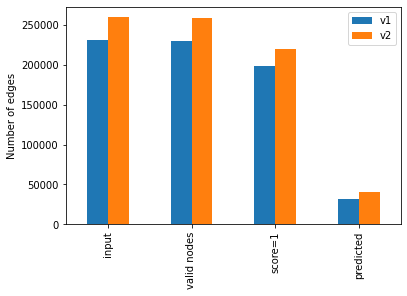

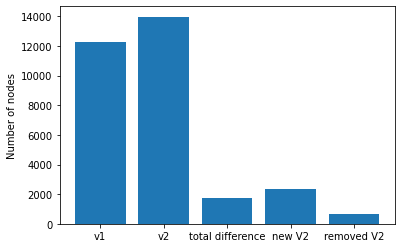

In [59]:
stats.plot.bar(ylabel="Number of edges")
plt.figure()
plt.bar(["v1", "v2", "total difference", "new V2", "removed V2"], [len(nodes_v1), len(nodes_v2), len(nodes_v2)-len(nodes_v1),
                                                           len(nodes_v2.difference(nodes_v1)), len(nodes_v1.difference(nodes_v2))])
plt.ylabel("Number of nodes")